# <center> **Compte-rendu projet Optimisation**
<div align = right> Camille Dubois & Florian Garbe

On pose la fonction suivante à minimiser :
$$
\begin{align*}
 f: p= \left(\begin{matrix} p_1 \\ \vdots\\ p_N \end{matrix}\right) \longrightarrow \sum_{i=0}^{N-1} \|p_{i+1}-R_i\Delta p_{i,i+1} -p_i \|_2^2 + \gamma \sum_{i, j \in L}\|p_j - R_i\Delta p_{i,j}-p_i\|_2^2
 \\
 c_1(p) = p_{,3} - \pi = \theta_i - \pi \leq 0 \\
 c_2(p) = p_{,3} + \pi = \theta_i + \pi \leq 0
 \end{align*}
$$



Ainsi les variables de décisions sont $p = \left(\begin{matrix} p_1 \\ \vdots \\ p_N\end{matrix}\right) \in \mathbb{M}_{3, N} $ au nombre de $3N$.

---

---

### Question 3.
&ensp;&ensp;&ensp; On réalise la fonction permettant de lire les données du fichier INTEL.txt qui contient 1227 lignes ODO, donc 3 681 incconues sont liées à ce jeu de données.

In [87]:
# on importe les modules nécessaires
import numpy as np
from casadi import *
import time
import matplotlib.pyplot as plt

In [41]:
def lec_don(f:str):
    """ Cette fonction retourne les deltap_i,i+1 associé au mesures d'odométrie
        ainsi que les deltap_i,j associé au mesures de fermetures
        
        return a tuple of array. 
            - The first array is the deltap_i,i+1 linked to the odométrie sorted
            in rising order.
            
            - The second one is linked to the closing sorted as well in rising
            order.
            
        parameters :
            - The file that contains the data"""

    ODO = np.zeros((1227, 3)) # l'array d'odométrie
    LOOP = np.zeros((256, 5)) # L'array de fermeture
    num_line = 0 # Le numéro de la ligne en cours
    
    with open(f) as file:
        for line in file:
            type, p1, p2, dx, dy, dtheta = line.split(' ')
            if type == "EDGE_ODO":
                ODO[num_line] = [float(dx), float(dy), float(dtheta)]
            if type == "EDGE_LOOP":
                #print(num_line -1227, type)
                LOOP[num_line - 1227] = [int(p1), int(p2), float(dx), float(dy), float(dtheta)]
            
            num_line +=1

    return (ODO, LOOP)



In [72]:
ODO, LOOP = lec_don("INTEL.txt")
# Attention ODO est constitué sur la i-ème ligne des informations de 
# Deltap_i,i+1, tandis que LOOP contient sur chaque les lignes les
# les informations i, j pour identifier le Deltap_i,j et les infos associées

---

&ensp; Il est nécessaire de définir dans un premier temps la fonction f à minimiser : on utilise pour cela le module <code>casadi

In [105]:
opti = casadi.Opti();
p = opti.variable(1227, 3) # on a 1227 poses qui contienent 3 inconnues chacune

# on constitue ensuite notre fonction f à minimiser
x1, y1, theta1 = p[0,0], p[0,1], p[0,2]
x, y , theta = 0, 0, 0
dx, dy , dtheta = ODO[0]
f = (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2
# on commence par les relations d'odométrie
for i in range(1226):
    x, y , theta = p[i,0], p[i,1], p[i,2]
    x1, y1, theta1 = p[i+1,0], p[i+1,1], p[i+1,2]
    dx, dy , dtheta = ODO[i+1]

    f += (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2

# Puis on ajoute les relations de fermetures (pour la question 5)
for k in range (256):
    i, j, dx, dy, dtheta = LOOP[k]
    xi, yi, thetai = p[i,0], p[i,1], p[i,2]
    xj, yj, thetaj = p[j,0], p[j,1], p[j,2]

    #f += (xj - np.cos(thetai)*dx - np.sin(thetai)*dy - xi)**2 + (yj - np.sin(thetai)*dx - np.cos(thetai)*dy - yi)**2 + (thetaj - dtheta - thetai)**2

opti.minimize(f)
# les contraintes 
opti.subject_to( p[2] - np.pi <=0)
opti.subject_to(p[2] + np.pi <=0)

# La solution à notre problème d'optimisation
opti.solver('ipopt');
sol = opti.solve();
res = sol.value(p)


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:    12215

Total number of variables............................:     3681
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5

print(res, res.shape)

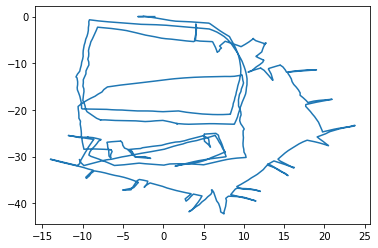

In [107]:
# on affiche ici le graphe des poses
plt.plot(res[:, 0], res[:, 1])
plt.show()

---

### Question 5
&ensp; on ajoute les relations de fermeture de boucle

In [109]:
opti = casadi.Opti();
p = opti.variable(1227, 3) # on a 1227 poses qui contienent 3 inconnues chacune

# on constitue ensuite notre fonction f à minimiser
x1, y1, theta1 = p[0,0], p[0,1], p[0,2]
x, y , theta = 0, 0, 0
dx, dy , dtheta = ODO[0]
f = (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2
# on commence par les relations d'odométrie
for i in range(1226):
    x, y , theta = p[i,0], p[i,1], p[i,2]
    x1, y1, theta1 = p[i+1,0], p[i+1,1], p[i+1,2]
    dx, dy , dtheta = ODO[i+1]

    f += (x1 - np.cos(theta)*dx - np.sin(theta)*dy - x)**2 + (y1 - np.sin(theta)*dx - np.cos(theta)*dy - y)**2 + (theta1 - dtheta - theta)**2

# Puis on ajoute les relations de fermetures (pour la question 5)
for k in range (256):
    i, j, dx, dy, dtheta = LOOP[k]
    xi, yi, thetai = p[i,0], p[i,1], p[i,2]
    xj, yj, thetaj = p[j,0], p[j,1], p[j,2]

    f += (xj - np.cos(thetai)*dx - np.sin(thetai)*dy - xi)**2 + (yj - np.sin(thetai)*dx - np.cos(thetai)*dy - yi)**2 + (thetaj - dtheta - thetai)**2

opti.minimize(f)
# les contraintes 
opti.subject_to( p[2] - np.pi <=0)
opti.subject_to(p[2] + np.pi <=0)

# La solution à notre problème d'optimisation
opti.solver('ipopt');
sol = opti.solve();
res = sol.value(p)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:    13495

Total number of variables............................:     3681
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2

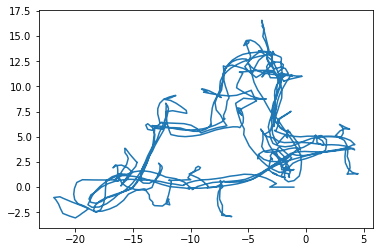

In [110]:
# on affiche ici le graphe des poses
plt.plot(res[:, 0], res[:, 1])
plt.show()